#Что это?
В этой тетрадке собраны свойства качества классификатора, обученного на данных задачи.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Первоначальные данные.

In [2]:
lhcb_data = pd.read_csv('Data/popularity-728days.csv')
lhcb_data.irow(range(0,3))

,Name,Configuration,ProcessingPass,FileType,Type,Creation-week,NbLFN,LFNSize,NbDisk,DiskSize,...,95,96,97,98,99,100,101,102,103,104
0,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,/LHCb/Collision10,/RealData/Reco08-MINBIAS-FIRST-14-NB/Stripping12d,MINIBIAS.DST,1,104591,67,0.317900,134,0.635799,...,12687,12687,12687,12687,12687,12687,12687,12687,12687,12687
1,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,/LHCb/Collision10,/RealData/Reco08/Stripping14,BHADRON.DST,1,104607,227,0.649204,980,2.819260,...,1631,1631,1631,1631,1631,1631,1631,1631,1631,1631
2,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,/LHCb/Collision10,/RealData/Reco08/Stripping14,CALIBRATION.DST,1,104607,355,1.370105,355,1.370105,...,0,0,0,474,708,708,708,708,708,708


Предобработанные данные.

In [3]:
from datapop.LHCb import DataPreprocessor
data1 = DataPreprocessor(data=lhcb_data).get_preprocessed_data()
data1.irow(range(0,3))

,ID,DiskSize,Creation,First,StartTime,Now,1,2,3,4,...,95,96,97,98,99,100,101,102,103,104
0,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0.635799,104591,104670,104660,104764,0,0,0,0,...,0,0,0,0,0,0,0,0,0,134
1,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,2.819260,104607,104676,104660,104764,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,1.370105,104607,104666,104660,104764,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Преселекция данных.

In [167]:
x11 = data[[str(i) for i in range(21, 53)]]
selected_data = x11[x11.sum(axis=1)!=0]
indexes = selected_data.index

Делим выблрку на обучение/тестирование.

In [168]:
from sklearn.cross_validation import train_test_split
ind_train, ind_test, _, _ = train_test_split(indexes, indexes, test_size=0.33, random_state=42)

Готовим несколько выборок для обучения. Записываем обученные классификаторы, выборки с метками, прогнозы.

In [199]:
%%time

probas = pd.DataFrame()
ys = pd.DataFrame()
xs = []
classifiers = []
periods = []

for k in range(0, 26):
    x = data[[str(i) for i in range(1+k, 53+k)]]
    X_train = (x).astype(np.float).values
    Y_train = (((data[[str(i) for i in range(53+k, 79+k)]]).sum(axis=1)>0)*1).astype(np.float).values
    xs.append(X_train[ind_test, :])
    ys[str(k)] = Y_train[ind_test]
    
    gbc = GradientBoostingClassifier(learning_rate=0.02, n_estimators=2500, max_depth=6, subsample=0.8)
    gbc.fit(X_train[ind_train, :], Y_train[ind_train])
    classifiers.append(gbc)
    
    
    proba = gbc.predict_proba(X_train[ind_test, :])[:,1]
    probas[str(k)] = proba
    
    periods.append(k)
    print k

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
CPU times: user 13min 36s, sys: 1.13 s, total: 13min 37s
Wall time: 13min 38s


Строим зависимоть вероятности принадлежности к классу 1 от времени для нескольких датасетов.

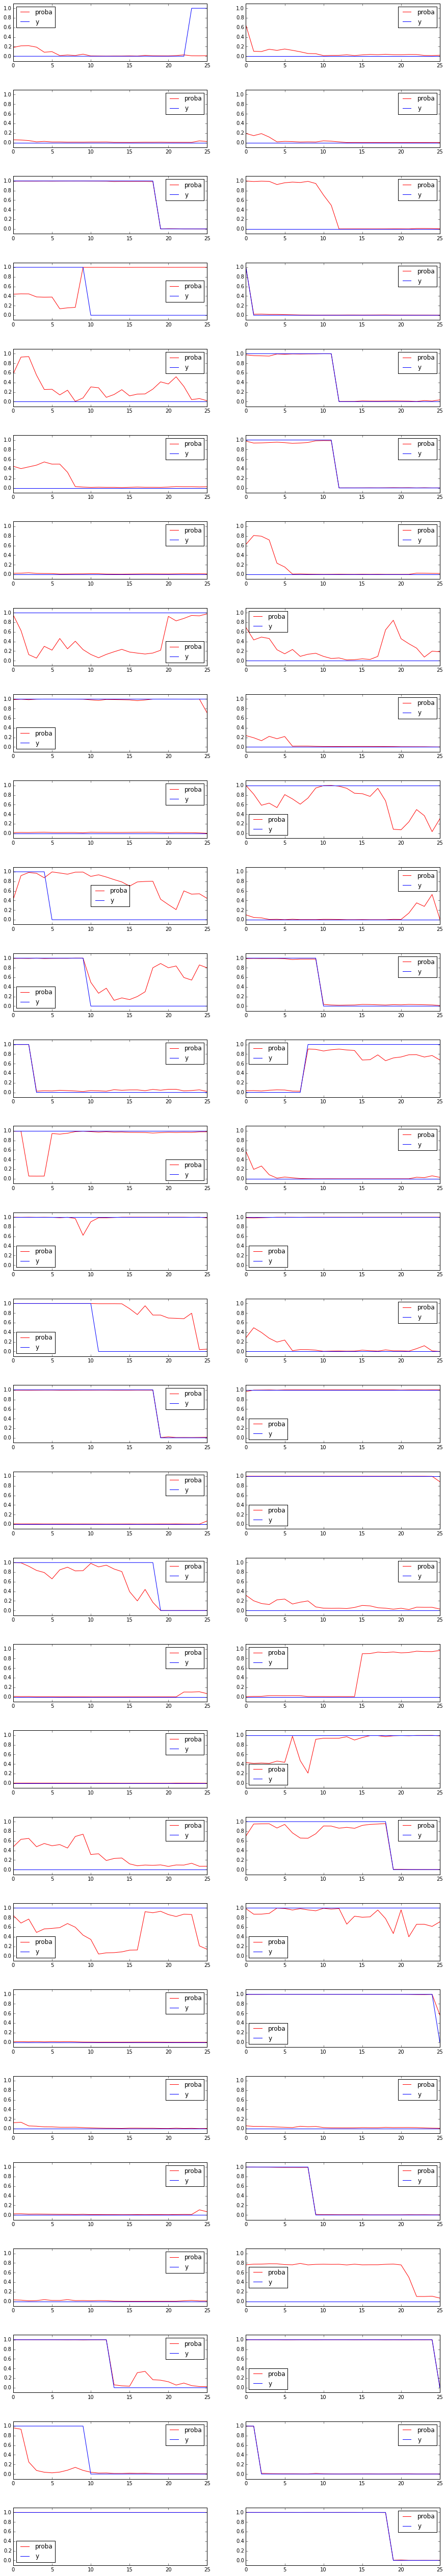

In [200]:
plt.figure(figsize=(15,90))
plt.subplots_adjust( hspace=.5)
for i in range(0,60):#менять тут
    plt.subplot(30,2,i)#и тут
    plt.plot(probas.irow([i]).values[0], label='proba')
    plt.plot(ys.irow([i]).values[0], label='y')
    plt.ylim(-0.1, 1.1)
    plt.legend(loc='best')
plt.show()

Зависимость качества классификации от времени при фиксированной вероятности. 

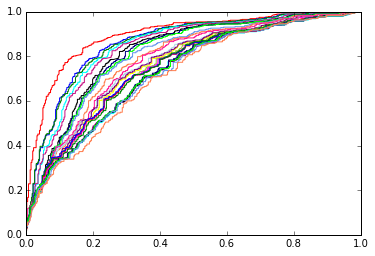

In [201]:
from sklearn.metrics import roc_curve, auc
aucs = []
for k in range(0, 26):
    fpr, tpr, _ = roc_curve(ys[str(k)].values, probas[str(0)].values)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr)
plt.show()

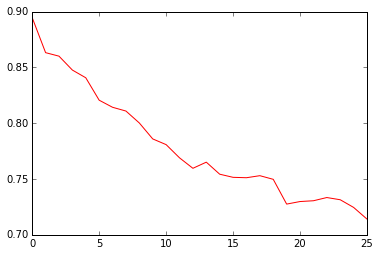

In [202]:
plt.plot(aucs)
plt.show()

Для сравнения строим две диаграммы.

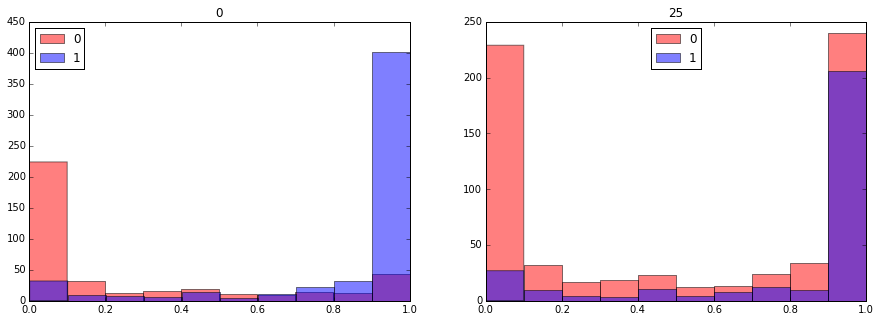

In [203]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
k=0
plt.hist(probas[str(0)].values[ys[str(k)].values==0], alpha=0.5, bins=10, label='0')
plt.hist(probas[str(0)].values[ys[str(k)].values==1], alpha=0.5, bins=10, label='1')
plt.title(str(k))
plt.legend(loc='best')

plt.subplot(1,2,2)
k=25
plt.hist(probas[str(0)].values[ys[str(k)].values==0], alpha=0.5, bins=10, label='0')
plt.hist(probas[str(0)].values[ys[str(k)].values==1], alpha=0.5, bins=10, label='1')
plt.title(str(k))
plt.legend(loc='best')
plt.show()

Зафиксируем классификатор. Строим зависимость качества классификатора от времени.

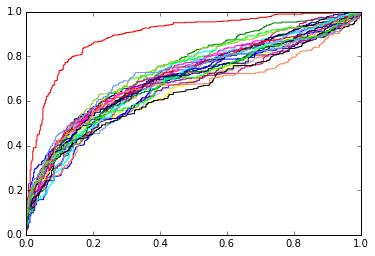

In [211]:
classifier = classifiers[0]
aucs = []
for k in range(0, 26):
    fpr, tpr, _ = roc_curve(ys[str(k)].values, classifier.predict_proba(xs[k])[:,1])
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr)
plt.show()

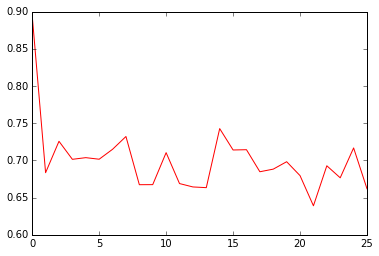

In [212]:
plt.plot(aucs)
plt.show()

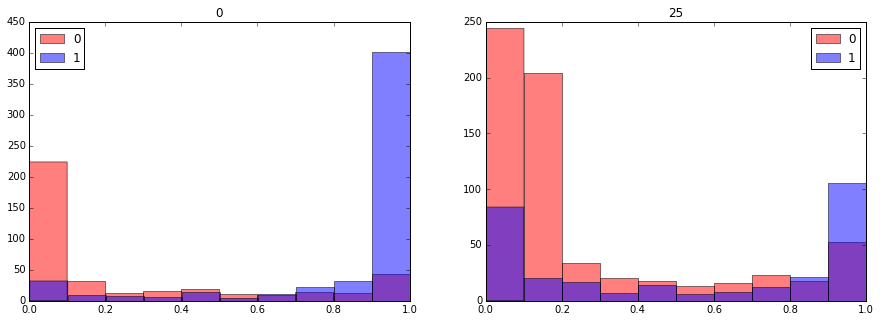

In [213]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
k=0
plt.hist(classifier.predict_proba(xs[k])[:,1][ys[str(k)].values==0], alpha=0.5, bins=10, label='0')
plt.hist(classifier.predict_proba(xs[k])[:,1][ys[str(k)].values==1], alpha=0.5, bins=10, label='1')
plt.title(str(k))
plt.legend(loc='best')

plt.subplot(1,2,2)
k=25
plt.hist(classifier.predict_proba(xs[k])[:,1][ys[str(k)].values==0], alpha=0.5, bins=10, label='0')
plt.hist(classifier.predict_proba(xs[k])[:,1][ys[str(k)].values==1], alpha=0.5, bins=10, label='1')
plt.title(str(k))
plt.legend(loc='best')
plt.show()